In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import glob
import numpy as np
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()

In [203]:
def clean_column_ids(col):
    return col.str.split("|").str[1]

def read_scores(path):
    df= pd.read_csv(path,   delimiter=r"\s+", comment="#", usecols=[0,2, 4,5], header=None)
    df.columns = ["sequence", "reference", "e-value", "score"]
    df.sort_values(by=["score"], inplace=True, ascending=False)
    df["sequence"] = clean_column_ids(df["sequence"])
    df.set_index("sequence", inplace=True)
    return df

In [304]:
df_hmms = read_scores("./../out/uniprot_sprot.40.multi-step/hmmsearch/P69340.out")
df_hmms.rename(columns={"score" : "hmms_score", "e-value" : "hmms_e-value"}, inplace=True)
print(df_hmms.shape)
print(df_hmms.dtypes)
df_hmms.head()

(121, 3)
reference        object
hmms_e-value      int64
hmms_score      float64
dtype: object


,reference,hmms_e-value,hmms_score
sequence,,,
B7LV40,P69340,0,1986.6
Q323D9,P69340,0,1986.3
B5YUD4,P69340,0,1985.6
Q7ACM1,P69340,0,1985.6
A7ZNP9,P69340,0,1985.6


In [305]:
df_phmm = read_scores("./../out/uniprot_sprot.40.multi-step/phmmer/P69340.out")
df_phmm.rename(columns={"score" : "phmm_score", "e-value" : "phmm_e-value"}, inplace=True)
print(df_phmm.shape)
print(df_phmm.dtypes)
df_phmm.head()

(121, 3)
reference        object
phmm_e-value    float64
phmm_score      float64
dtype: object


,reference,phmm_e-value,phmm_score
sequence,,,
P69340,sp|P69340|MDTB_SHIFL,0.0,2214.9
A7ZNP8,sp|P69340|MDTB_SHIFL,0.0,2202.1
Q8X7J4,sp|P69340|MDTB_SHIFL,0.0,2201.2
A1ACT0,sp|P69340|MDTB_SHIFL,0.0,2200.3
B1LNW6,sp|P69340|MDTB_SHIFL,0.0,2200.3


In [306]:
df = pd.concat([df_phmm, df_hmms], axis=1)
print(df.shape)
df.head()

(121, 6)


,reference,phmm_e-value,phmm_score,reference,hmms_e-value,hmms_score
P69340,sp|P69340|MDTB_SHIFL,0.0,2214.9,P69340,0,1887.7
A7ZNP8,sp|P69340|MDTB_SHIFL,0.0,2202.1,P69340,0,1897.8
Q8X7J4,sp|P69340|MDTB_SHIFL,0.0,2201.2,P69340,0,1896.5
A1ACT0,sp|P69340|MDTB_SHIFL,0.0,2200.3,P69340,0,1897.6
B1LNW6,sp|P69340|MDTB_SHIFL,0.0,2200.3,P69340,0,1897.6


<AxesSubplot:xlabel='hmms_score', ylabel='phmm_score'>

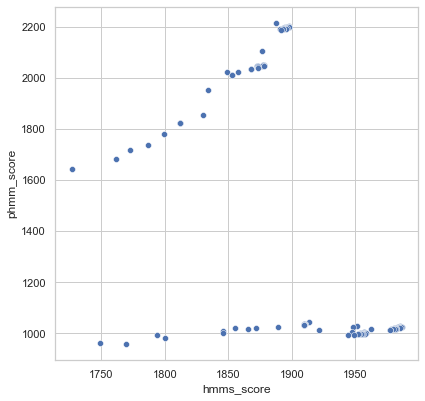

In [307]:
f, ax = plt.subplots(figsize=(6.5,6.5))
sb.set_theme(style="whitegrid")
#ax.set(yscale="log")
sb.scatterplot(ax=ax, x="hmms_score", y="phmm_score", data=df)

In [294]:
def load_scores(path):
    hmms_files = glob.glob(path.replace("$$$", "hmmsearch"))
    phmm_files = glob.glob(path.replace("$$$", "phmmer"))
    files = list(zip(hmms_files, phmm_files))
    dfs = []
    for filename in files[:10]:
        hmms_df = read_scores(filename[0])
        phmm_df = read_scores(filename[1])
        hmms_df.rename(columns={"score" : "hmms_score", "e-value" : "hmms_e-value"}, inplace=True)
        phmm_df.rename(columns={"score" : "phmm_score", "e-value" : "phmm_e-value"}, inplace=True)
        phmm_df.drop(["reference"], axis=1, inplace=True)
        df = pd.concat([phmm_df, hmms_df], axis=1)
        df["phmm_score"] = scaler.fit_transform(df["phmm_score"].values.reshape(-1,1))
        df["hmms_score"] = scaler.fit_transform(df["hmms_score"].values.reshape(-1,1))
        dfs.append(df)
    frame = pd.concat(dfs, axis=0)
    return frame

def plot_scores(frame):
    f, ax = plt.subplots(figsize=(6.5,6.5))
    sb.set_theme(style="whitegrid")
    #ax.set(yscale="log", xscale="log")
    sb.scatterplot(x="hmms_score", y="phmm_score", hue="reference", ax=ax, data=frame)
    #if ax.get_legend():
        #ax.get_legend().remove()

In [295]:
df = load_scores("./../out/uniprot_sprot.40.multi-step/$$$/*.out")
df.sample(10)

,phmm_e-value,phmm_score,reference,hmms_e-value,hmms_score
Q8YQX8,5.100000e-60,0.382303,Q36863,1.200000e-99,0.854483
A5I6W1,8.200000e-56,0.343820,Q36863,1.000000e-102,0.923448
C3MFT5,5.900000e-45,0.434066,A4G9H5,1.700000e-51,0.678392
A8FJZ3,2.000000e-57,0.358708,Q36863,1.400000e-100,0.875172
Q33C07,7.500000e-43,0.225281,Q36863,5.400000e-86,0.546897
Q3MFR5,1.900000e-55,0.340449,Q36863,6.200000e-100,0.860690
B2TPB9,7.800000e-54,0.325843,Q36863,2.200000e-102,0.915862
B1JMQ4,2.800000e-64,0.559214,Q83P38,1.100000e-68,0.673367
Q5WTE8,1.100000e-51,0.209540,A4G921,2.400000e-83,0.592637
B8D8C8,1.900000e-40,0.349169,A4G712,1.000000e-53,0.561030


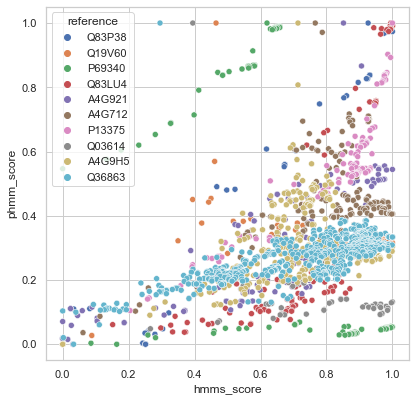

In [296]:
plot_scores(df)

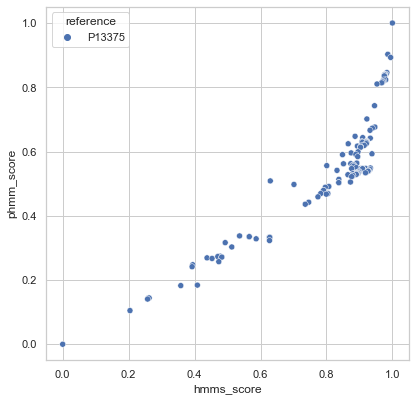

In [299]:
plot_scores(df[df["reference"]=="P13375"])